1 下载数据。

In [1]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = f'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = "datasets"
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

# fetch_housing_data()  # 下载housing.csv数据集

2 加载数据。

In [2]:
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [3]:
housing = load_housing_data()
housing.head()  # 查看数据前5行
housing.info()  # 数据集的简单描述，总行数、属性的类型、非空值的数量
# housing['ocean_proximity'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing.describe()  # 特征的数值属性（个数、最大最小值、均值）

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


绘制每个属性的直方图

array([[<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'housing_median_age'}>],
       [<AxesSubplot:title={'center':'total_rooms'}>,
        <AxesSubplot:title={'center':'total_bedrooms'}>,
        <AxesSubplot:title={'center':'population'}>],
       [<AxesSubplot:title={'center':'households'}>,
        <AxesSubplot:title={'center':'median_income'}>,
        <AxesSubplot:title={'center':'median_house_value'}>]],
      dtype=object)

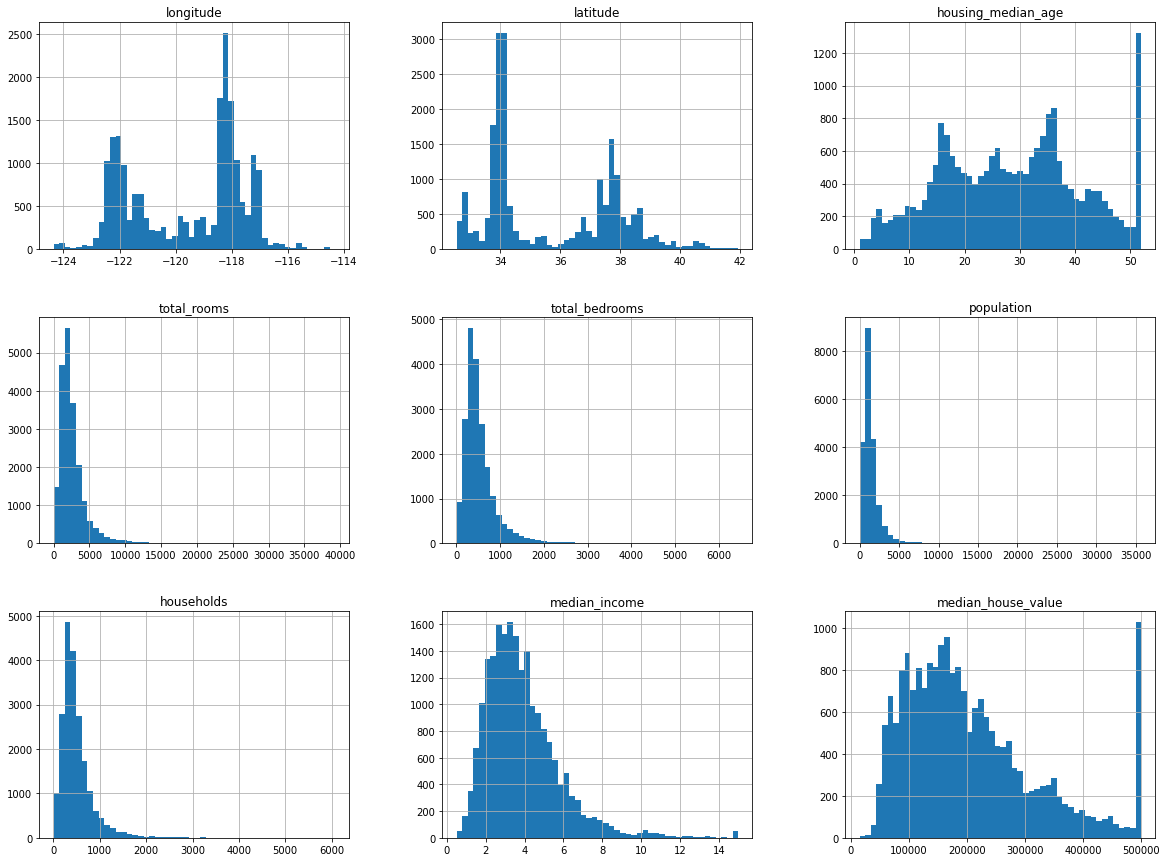

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))

创建测试集

In [6]:
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))  # 生成随机索引(属性为列表)
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]  # 按索引取值

计算每个实例的哈希值，若该哈希值小于等于最大哈希值的20%，则放入测试集

In [7]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
def split_train_test_by_id(data, test_ratio, id_column): 
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))  # 对ids的每一列执行test_set_check()
    return data.loc[~in_test_set], data.loc[in_test_set]  # loc只能用字符型标签来索引。 loc[~in_test_set]是取反操作

housing_with_id = housing.reset_index()  # 添加行索引("index")
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

用sklearn中现有的轮子进行数据集划分

In [8]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)  # 和之前定义的split_train_test几乎一样

预测房价中位数，人的收入中位数很重要，给收入中位数分个类

<AxesSubplot:>

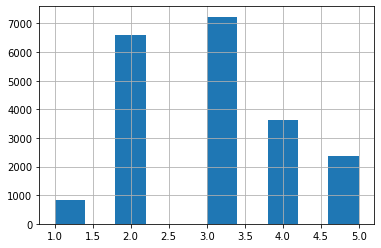

In [9]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6, np.inf], labels=[1, 2, 3, 4, 5])  # 把收入水平分为5类
housing['income_cat'].hist()

根据收入中位数的分布，划分数据集

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [11]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)  # 查看测试集中各收入类别的占比

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [12]:
for set_ in (strat_train_set, strat_test_set):  # 删除收入的类别标签
    set_.drop("income_cat", axis=1, inplace=True)

对数据集进行更深一步的探索，首先创建一个训练集的副本

In [13]:
housing = strat_train_set.copy()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

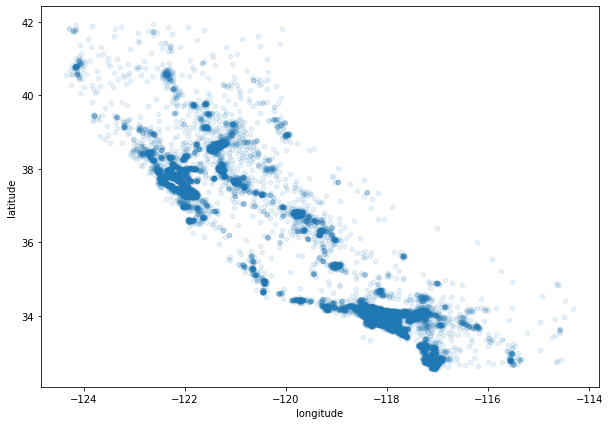

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1, figsize=(10, 7))  # alpha设置散点的透明度（密度低的地方更透明）;figsize设置图形大小

In [15]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

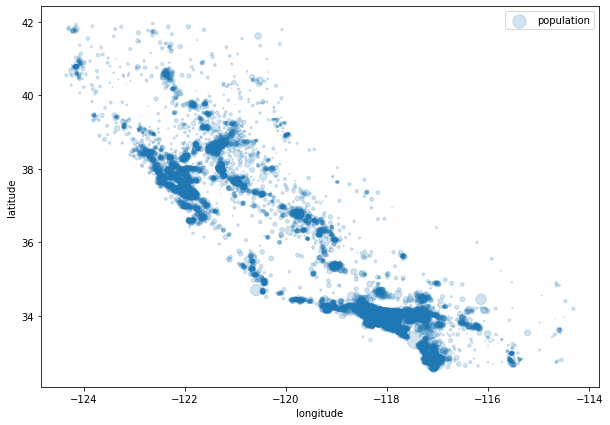

In [16]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.2, s=housing["population"]/100, label="population", figsize=(10, 7))  

In [17]:
corr_matrix = housing.corr()  # 计算每对属性之间的标准相关系数（皮尔逊系数）；其值越接近1有越强的正相关，接近-1则是负相关，趋近0则说明没有线性相关性
corr_matrix["median_house_value"].sort_values(ascending=False)  # ascending参数表示是否从小到大排序

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

绘制出每个数值属性相对于其他数值属性的相关性

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

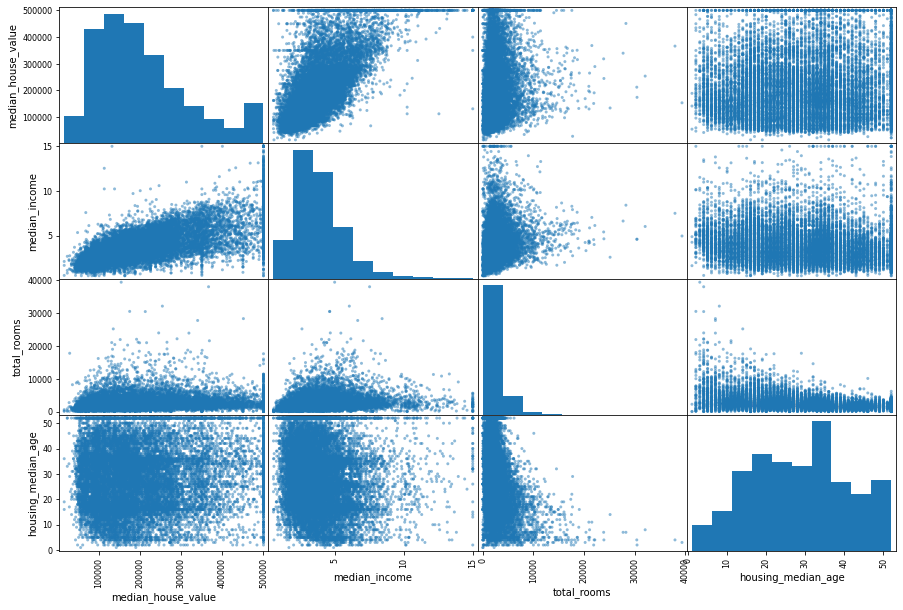

In [18]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(15, 10))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

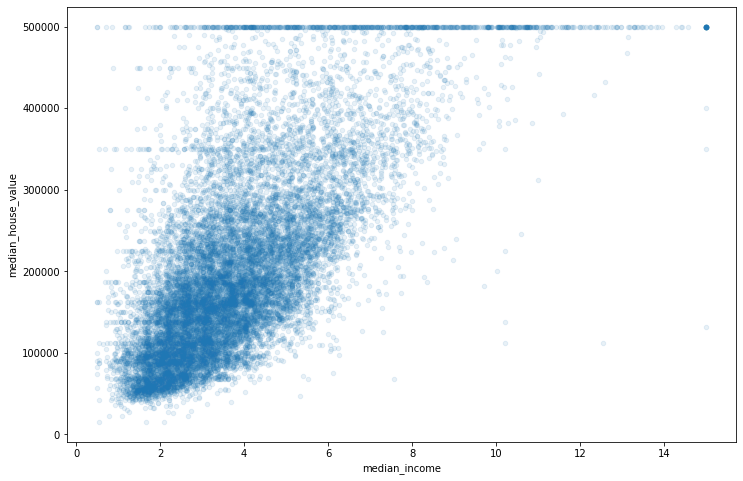

In [19]:
housing.plot(kind="scatter", y="median_house_value", x="median_income", alpha=0.1, figsize=(12, 8))

尝试不同属性的组合

In [20]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]  # 每个家庭拥有的房子数量
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]  # 每个房子中的卧室数量
housing["population_per_household"] = housing["population"] / housing["households"]  # 每个家庭中的人口数量
# 再查看相关矩阵
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

3 数据准备

In [21]:
housing = strat_train_set.drop("median_house_value", axis=1)  # median_house_vallue作为标签
housing_table = strat_train_set["median_house_value"].copy()

数据清理：对total_bedrooms中的空值进行处理

In [22]:
housing.dropna(subset=["total_bedrooms"])  # 删除相应的区域
housing.drop("total_bedrooms", axis=1)  # 放弃整个属性列
median = housing["total_bedrooms"].median()  # 将确实的值设为某个值（0、中位数、平均数等）
housing["total_bedrooms"].fillna(median, inplace=True)

In [23]:
housing["total_bedrooms"]

12655     797.0
15502     855.0
2908      310.0
14053     519.0
20496     646.0
          ...  
15174    1231.0
12661    1422.0
19263     166.0
19140     580.0
19773     222.0
Name: total_bedrooms, Length: 16512, dtype: float64

用sklearn现有轮子处理缺失值

In [70]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")  #创建一个SimpleImputer实例，用来计算"median"
housing_num = housing.drop("ocean_proximity", axis=1)  # 去掉数据集中的文本属性
imputer.fit(housing_num)  # 将imputer实例适配到数据集，计算出每个属性的中位数
imputer.statistics_  # 计算了每个属性的中位数值，并存储在实例变量statistics_中

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


In [68]:
X = imputer.transform(housing_num)  # 使用实例imputer将缺失值替换成中位数值
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)  #X是一个ndarray，可以将其转换为DataFrame

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


查看文本属性"ocean_proximity"，发现其是类别属性，每个值代表一个分类。为此，可将这些值转换成数字

In [35]:
housing_cat = housing[["ocean_proximity"]]  # 此处的[[""]]返回DataFrame类型
# housing_cat = housing["ocean_proximity"]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


通过sklearn将标签文本转为数字

In [48]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)  # 参数要求类型为DataFrame
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [28]:
ordinal_encoder.categories_  # 通过该实例变量获取类别

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

使用sklearn的OneHotEncode编码器

In [55]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot  # scipy稀疏矩阵
housing_cat_1hot.data

array([1., 1., 1., ..., 1., 1., 1.])

In [56]:
cat_encoder.categories_  # 同样可通过categories_实例变量获取类别

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

自定义转换器

In [72]:
from sklearn.base import BaseEstimator, TransformerMixin
room_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
class CombineAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, room_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, room_ix]
            return np.c_[X, rooms_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household]
attr_adder = CombineAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
housing_extra_attribs
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)  #X是一个ndarray，可以将其转换为DataFrame

转换流水线

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("attribs_adder", CombineAttributesAdder()),
    ("std_scaler", StandardScaler()),
])
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [82]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
housing_prepared = full_pipeline.fit_transform(housing)

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])